In [1]:
import numpy as np
import scipy
import pandas as pd
import math
import random
import sklearn
from nltk.corpus import stopwords
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds

In [2]:
clubs_df = pd.read_csv('data/clubs.csv')
clubs_category = pd.read_csv('not_used/quinn_clubs.csv', delimiter= '|')[['Category']]
clubs_df = pd.concat([clubs_df,clubs_category ], axis=1)
exceptions_club_names = {'Vole':'Vole, the Penn State Ballet Club (VOLE)', 'Design Association':'PHOTOGRAPHY CLUB (PC)'}

In [3]:
articles_df = pd.read_csv('summaries3.csv') #articles are summaries of the clubs
articles_df.tail(5)

,name,summary
1020,Youth Empowerment Program (YEP),Youth Empowerment Program (YEP)\nThe Youth Emp...
1021,ZETA BETA TAU (ZBT),ZETA BETA TAU (ZBT)\nZeta Beta Tau is a non-pl...
1022,ZETA PHI BETA (ZPB),ZETA PHI BETA (ZPB)\n
1023,ZETA TAU ALPHA (ZTA),ZETA TAU ALPHA (ZTA)\nTo make a difference in ...
1024,GLOBE,GLOBE


In [4]:
# clubs_df = pd.concat([clubs_df,articles_df['summary'] ], axis=1)

In [5]:
#add unknown articles
unk = '<UNKNOWN>'
unknown_articles_df = pd.DataFrame([['<UNKNOWN>', '<UNKNOWN>']], columns=['name','summary'])
articles_df = articles_df.append(unknown_articles_df, ignore_index=True)

In [6]:
# unknown_articles_df = pd.DataFrame([['<UNKNOWN>', '<UNKNOWN>', '<UNKNOWN>', '<UNKNOWN>', '<UNKNOWN>', '<UNKNOWN>']], columns=['name','mission', 'mk', 'wk', 'Category', 'summary'])
# clubs_df = clubs_df.append(unknown_articles_df, ignore_index=True)
# clubs_df =unknown_articles_df.append(clubs_df, ignore_index=True)

In [7]:
# clubs_df.head(5)

In [8]:
survey_df = pd.read_csv('data/survey_clean.csv')

In [9]:
survey_df.columns

Index(['psu_id', 'year', 'interest', 'o_interest', 'sport', 'greek',
       'ge_dislike', 'gpa', 'ge_like', 'ethnicity', 'class_dislike',
       'class_like', 'gender', 'club1', 'club2', 'major', 'club3', 'o_major',
       'club4', 'club5', 'club6'],
      dtype='object')

In [10]:
import random
users_clubs_interactions = []
users = set() #keep track of all unique users
for i, row in survey_df.iterrows():
    temp_clubs = [row['club1'],row['club2'],row['club3'],
                  row['club4'],row['club5'],row['club6']]
    user_psu_id = row['psu_id']
    for j, club in enumerate(temp_clubs):
        if( user_psu_id not in users and str(club).lower() != 'nan'):
            if(club in exceptions_club_names):
                users_clubs_interactions.append([user_psu_id, exceptions_club_names[club], .5+random.random()*10])
            else:
                users_clubs_interactions.append([user_psu_id, club, .5+random.random()*10])
    users.add(user_psu_id)
users_clubs_interactions_df = pd.DataFrame(users_clubs_interactions, columns=['psu_id', 'club', 'strength'])

In [11]:
def get_items_interacted(psuid, interactions_df):
    # Get the user's data and merge in the club information.
    try:
        interacted_items = interactions_df.loc[psuid]['club']
    except:
        return []
    return set(interacted_items if type(interacted_items) == pd.Series else [interacted_items])

In [12]:
interactions_train_df, interactions_test_df = train_test_split(users_clubs_interactions_df,
                                   test_size=0.20,
                                   random_state=random.randrange(99))
print('# interactions on Train set: %d' % len(interactions_train_df))
print('# interactions on Test set: %d' % len(interactions_test_df))

# interactions on Train set: 152
# interactions on Test set: 39


In [13]:
interactions_full_indexed_df = users_clubs_interactions_df.set_index('psu_id')
interactions_train_indexed_df = interactions_train_df.set_index('psu_id')
interactions_test_indexed_df = interactions_test_df.set_index('psu_id')

In [14]:
EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS = 100

class ModelEvaluator:

    def get_not_interacted_items_sample(self, person_id, sample_size, seed=42):
        interacted_items = get_items_interacted(person_id, interactions_full_indexed_df)
        all_items = set(users_clubs_interactions_df['club'])
        non_interacted_items = all_items - interacted_items

        random.seed(seed)
        non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
        return set(non_interacted_items_sample)

    def _verify_hit_top_n(self, item_id, recommended_items, topn):        
            try:
                index = next(i for i, c in enumerate(recommended_items) if c == item_id)
            except:
                index = -1
            hit = int(index in range(0, topn))
            return hit, index

    def evaluate_model_for_user(self, model, person_id):
        #Getting the items in test set
        interacted_values_testset = interactions_test_indexed_df.loc[person_id]
        if type(interacted_values_testset['club']) == pd.Series:
            person_interacted_items_testset = set(interacted_values_testset['club'])
        else:
            person_interacted_items_testset = set([interacted_values_testset['club']])  
        interacted_items_count_testset = len(person_interacted_items_testset) 

        #Getting a ranked recommendation list from a model for a given user
        person_recs_df = model.recommend(person_id, 
                                               items_to_ignore=get_items_interacted(person_id, 
                                                                                    interactions_train_indexed_df), 
                                               topn=10000000000)

        hits_at_5_count = 0
        hits_at_10_count = 0
        #For each item the user has interacted in test set
        for item_id in person_interacted_items_testset:
            #Getting a random sample (100) items the user has not interacted 
            #(to represent items that are assumed to be no relevant to the user)
            non_interacted_items_sample = self.get_not_interacted_items_sample(person_id, 
                                                                          sample_size=EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS, 
                                                                          seed=len(item_id)%(11))

            #Combining the current interacted item with the 100 random items
            items_to_filter_recs = non_interacted_items_sample.union(set([item_id]))

            #Filtering only recommendations that are either the interacted item or from a random sample of 100 non-interacted items
            valid_recs_df = person_recs_df[person_recs_df['club'].isin(items_to_filter_recs)]                    
            valid_recs = valid_recs_df['club'].values
            #Verifying if the current interacted item is among the Top-N recommended items
            hit_at_5, index_at_5 = self._verify_hit_top_n(item_id, valid_recs, 5)
            hits_at_5_count += hit_at_5
            hit_at_10, index_at_10 = self._verify_hit_top_n(item_id, valid_recs, 10)
            hits_at_10_count += hit_at_10

        #Recall is the rate of the interacted items that are ranked among the Top-N recommended items, 
        #when mixed with a set of non-relevant items
        recall_at_5 = hits_at_5_count / float(interacted_items_count_testset)
        recall_at_10 = hits_at_10_count / float(interacted_items_count_testset)

        person_metrics = {'hits@5_count':hits_at_5_count, 
                          'hits@10_count':hits_at_10_count, 
                          'interacted_count': interacted_items_count_testset,
                          'recall@5': recall_at_5,
                          'recall@10': recall_at_10}
        return person_metrics

    def evaluate_model(self, model):
        #print('Running evaluation for users')
        people_metrics = []
        for idx, person_id in enumerate(list(interactions_test_indexed_df.index.unique().values)):
            #if idx % 100 == 0 and idx > 0:
            #    print('%d users processed' % idx)
            person_metrics = self.evaluate_model_for_user(model, person_id)  
            person_metrics['_person_id'] = person_id
            people_metrics.append(person_metrics)
        print('%d users processed' % idx)

        detailed_results_df = pd.DataFrame(people_metrics) \
                            .sort_values('interacted_count', ascending=False)
        
        global_recall_at_5 = detailed_results_df['hits@5_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        global_recall_at_10 = detailed_results_df['hits@10_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        
        global_metrics = {'modelName': str(model),
                          'recall@5': global_recall_at_5,
                          'recall@10': global_recall_at_10}    
        return global_metrics, detailed_results_df
    
model_evaluator = ModelEvaluator()  

In [15]:
#Start of Content Based Filtering
stopwords_list = stopwords.words('english')
vectorizer = TfidfVectorizer(analyzer='word',
                     ngram_range=(1, 2),
                     min_df=0.003,
                     max_df=0.5,
                     max_features=2000,
                     stop_words=stopwords_list)
item_ids = articles_df['name'].tolist()
tfidf_matrix = vectorizer.fit_transform(articles_df['summary'])
tfidf_feature_names = vectorizer.get_feature_names()
tfidf_matrix

<1026x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 234493 stored elements in Compressed Sparse Row format>

In [16]:
# #Word2Vec Embeddings 
# from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences
# from keras.utils import to_categorical
# import gensim
# from gensim.models import Word2Vec
# from gensim.utils import simple_preprocess
# from gensim.models.keyedvectors import KeyedVectors

# NUM_WORDS=22000
# tokenizer = Tokenizer(num_words=NUM_WORDS,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\'',lower=True)
# tokenizer.fit_on_texts(articles_df['summary'])
# word_index = tokenizer.word_index
# print('Found %s unique tokens.' % len(word_index))

In [17]:
# word_vectors = KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin', binary=True)

# EMBEDDING_DIM=300
# vocabulary_size=min(len(word_index)+1,NUM_WORDS)
# embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))
# for word, i in word_index.items():
#     if i>=NUM_WORDS:
#         continue
#     try:
#         embedding_vector = word_vectors[word]
#         embedding_matrix[i] = embedding_vector
#     except KeyError:
#         embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25),EMBEDDING_DIM)

# del(word_vectors) #clear memory

In [18]:
# #tfidf features embedding matrix
# new_tfidf_embedding = np.zeros((tfidf_matrix.shape[0], EMBEDDING_DIM))
# print(new_tfidf_embedding.shape)
# for i in range(tfidf_matrix.shape[0]):
#     tvec = tfidf_matrix[i:i+1].todense().tolist()[0]
# #     print(tvec[0].tolist()[0])
    
#     total_weight = 0
#     w2vec = np.zeros((EMBEDDING_DIM, ))
#     for j, fname in enumerate(tfidf_feature_names):
#         words = fname.split()
#         indexes = [word_index[wd] for wd in words]
#         w2vec =np.sum([w2vec, tvec[j]*np.mean(np.array([embedding_matrix[index] for index in indexes]), axis = 0)], axis=0)
#         total_weight+=tvec[j]
#     new_tfidf_embedding[i] = w2vec/total_weight
# tfidf_matrix = new_tfidf_embedding

In [19]:
not_found = set()
def get_article_vector(article_name):
    index = 0
    if(article_name in item_ids):
        index = item_ids.index(article_name)
    elif (article_name in exceptions_club_names):
        index = item_ids.index(exceptions_club_names[article_name])
    else:
        not_found.add(article_name)
        index = item_ids.index(unk)
    return tfidf_matrix[index:index+1]

def get_article_vectors(article_names):
    article_features_lst = [get_article_vector(item) for item in article_names]
    article_features_matrix = scipy.sparse.vstack(article_features_lst)
    return article_features_matrix

def get_user_interactions(psu_id, user_survey_responses_df):
    interaction_clubs = user_survey_responses_df.loc[psu_id]
    temp_clubs = [interaction_clubs['club1'], interaction_clubs['club2'], interaction_clubs['club3'],
                    interaction_clubs['club4'],interaction_clubs['club5'],interaction_clubs['club6']]
    
    #Weights the clubs interaction
    #interaction_clubs_likes = interaction_clubs['likes']
    #interaction_clubs_dislikes = interaction_clubs['dislikes']
    
    #create a list of clubs user in
    clubs_name_user_in = []
    for cname in temp_clubs:
        if(str(cname).lower() != 'nan'):
            clubs_name_user_in.append(cname)
  
    #If the user is new and has no previously joined clubs
    if len(clubs_name_user_in) == 0:
        return None
 
    #average and normalize vector
    user_profile_vector = get_article_vectors(clubs_name_user_in)
    temp = np.array([[1.00] for _ in range(len(clubs_name_user_in))]).reshape(-1,1)
    user_profile_vector_avg = np.sum(user_profile_vector.multiply(temp), axis=0)/ np.sum(temp)
    user_profile_vector_norm = sklearn.preprocessing.normalize(user_profile_vector_avg, axis = 1)
    return user_profile_vector_norm

def get_users_interactions():
    user_survey_responses_df = survey_df[['psu_id','club1','club2','club3',
                                           'club4','club5','club6']].set_index('psu_id')
    users = {}
    for psu_id in user_survey_responses_df.index.unique():
        users[psu_id] = get_user_interactions(psu_id, user_survey_responses_df)
    return users

In [20]:
from scipy import sparse
not_found = set()
def get_article_vector(article_name):
    index = 0
    if(article_name in item_ids):
        index = item_ids.index(article_name)
    elif (article_name in exceptions_club_names):
        index = item_ids.index(exceptions_club_names[article_name])
    else:
        not_found.add(article_name)
        index = item_ids.index(unk)
    return sparse.csr_matrix(tfidf_matrix[index:index+1])

def get_article_vectors(article_names):
    article_features_lst = [get_article_vector(item) for item in article_names]
    article_features_matrix = scipy.sparse.vstack(article_features_lst)
    return article_features_matrix

def get_user_interactions(psu_id, user_survey_responses_df):
    interaction_clubs = user_survey_responses_df.loc[psu_id]
    temp_clubs = [interaction_clubs['club1'], interaction_clubs['club2'], interaction_clubs['club3'],
                    interaction_clubs['club4'],interaction_clubs['club5'],interaction_clubs['club6']]
    
    #Weights the clubs interaction
    #interaction_clubs_likes = interaction_clubs['likes']
    #interaction_clubs_dislikes = interaction_clubs['dislikes']
    
    #create a list of clubs user in
    clubs_name_user_in = []
    for cname in temp_clubs:
        if(str(cname).lower() != 'nan'):
            clubs_name_user_in.append(cname)
  
    #If the user is new and has no previously joined clubs
    if len(clubs_name_user_in) == 0:
        return None
 
    #average and normalize vector
    user_profile_vector = get_article_vectors(clubs_name_user_in)
    temp = np.array([[1.00] for _ in range(len(clubs_name_user_in))]).reshape(-1,1)
    user_profile_vector_avg = np.sum(user_profile_vector.multiply(temp), axis=0)/ np.sum(temp)
    try:
        user_profile_vector_norm = sklearn.preprocessing.normalize(user_profile_vector_avg, axis = 1)
    except:
        user_profile_vector_norm = None
    return user_profile_vector_norm

def get_users_interactions():
    user_survey_responses_df = survey_df[['psu_id','club1','club2','club3',
                                           'club4','club5','club6']].set_index('psu_id')
    users = {}
    for psu_id in user_survey_responses_df.index.unique():
        users[psu_id] = get_user_interactions(psu_id, user_survey_responses_df)
    return users

In [21]:
user_profiles = get_users_interactions()
def relevant_words_to_user(psu_id):    
    user = user_profiles[psu_id]
    words_relevancy = pd.DataFrame(sorted(
        zip(tfidf_feature_names, user.flatten().tolist()),
        key=lambda item: -item[1])[:20],
                 columns=['token', 'relevance'])
    return words_relevancy

In [22]:
dylon_id = 'dbs5306'
relevant_words_to_user(dylon_id)

,token,relevance
0,computer,0.427822
1,groups,0.298524
2,group,0.261521
3,theory,0.240256
4,program,0.230480
5,knowledge,0.215828
6,bachelor,0.183224
7,data,0.179659
8,degrees,0.168731
9,software,0.159066


In [23]:
class ContentBasedFilter(object):
    """
        Reuseable ContentBasedFiltering class (for both clubs and courses)
    """
    def __init__(self, items_df=None):
        self.MODEL_NAME = 'Content Based'
        self.item_ids = item_ids
        self.clubs_df = clubs_df
    
    def __str__(self):
        return self.MODEL_NAME
    
    def _get_similar_items_to_user(self, psu_id, topn=1000):
        #Computes similarity between the user and the items in the tfidf matrix
        cosine_similarities = cosine_similarity(user_profiles[psu_id], tfidf_matrix)
        #Sort for topn similar items
        similar_indices = cosine_similarities.argsort().flatten()[-topn:]
        #Sort by similar items by similarity
        similar_items = sorted([(item_ids[i], cosine_similarities[0,i]) for i in similar_indices], key=lambda x: -x[1])
        return similar_items
    def recommend(self, psu_id, items_to_ignore=[], topn=15, verbose=False):
        similar_items = self._get_similar_items_to_user(psu_id)
        #get rid of ignore items
        similar_items_filtered = list(filter(lambda x: x[0] not in items_to_ignore, similar_items))
        #print(items_to_ignore)
        recommendations_df = pd.DataFrame(similar_items_filtered, columns=['club', 'strength']).head(topn)
        #print(recommendations_df['club'].values)
        return recommendations_df
    

In [24]:
#Content Based Filter #2( User )
survey_df = pd.read_csv('xgboost_data.csv')
survey_df.drop(['Unnamed: 0'], axis=1, inplace=True)
lookup_df = survey_df.set_index('psu_id')

clubs = survey_df[['club1', 'club2', 'club3', 'club4', 'club5', 'club6']]
X_cols = survey_df.columns.values.tolist()
for item in ['club1', 'club2', 'club3', 'club4', 'club5', 'club6']:
    X_cols.remove(item)
    
train = []
exceptions_club_names = {'Vole':'Vole, the Penn State Ballet Club (VOLE)', 'Design Association':'PHOTOGRAPHY CLUB (PC)'}
for i, row in survey_df.iterrows():
    temp_clubs = [row['club1'],row['club2'],row['club3'],
                  row['club4'],row['club5'],row['club6']]
    for j, club in enumerate(temp_clubs):
        if(str(club).lower() != 'nan'):
            if(club in exceptions_club_names):
                train.append(survey_df.loc[i][X_cols].values.tolist() + [exceptions_club_names[club]])
#                 print(len(survey_df.loc[i][X_cols].values.tolist() + [exceptions_club_names[club]]))
            else:
                train.append(survey_df.loc[i][X_cols].values.tolist() + [club])
#                 print(len(survey_df.loc[i][X_cols].values.tolist() + [club]))
train_df = pd.DataFrame(train, columns = X_cols + ['club'])
X_cols.remove('psu_id')

y_cols = ['club']
user_ids = train_df['psu_id'].tolist()

y_ids = train_df.club.unique().tolist()
label = []
for i, row in train_df.iterrows():
    label.append(y_ids.index(row['club']))

train = train_df[X_cols]
y = pd.DataFrame(label, columns=['label'])

model = xgb.Booster({'nthread':4})
model.load_model('usr_cotent_filter.model')

In [25]:
class Xgboost_Lightbgm(object):
    def __init__(self, xgbgm_model, task = 'club'):
        self.model = xgbgm_model
        self.task = task
        self.MODEL_NAME = 'XGboost and LightBgm'
    def __str__(self):
        return ''.join((self.MODEL_NAME, ' to recommend ', self.task))
    
    def recommend(self, psuid, topn=5,items_to_ignore=[], verbose=False):
        """
            recommend based on XGBoost model
        """
        dtest = xgb.DMatrix(lookup_df[X_cols].loc[psuid].values.reshape(1,len(train.columns.values)))
        prediction_prob = self.model.predict(dtest)
        recommendation_indexes = np.argsort(prediction_prob[0])[::-1][:topn]
        recommendations = []
        for i in recommendation_indexes:
            recommendations.append([y_ids[i], prediction_prob[0][i]])
        recommendations_df = pd.DataFrame(recommendations, columns = ['club', 'strength'])
        return recommendations_df

In [26]:
#Collaborative Filtering model (Memory-based and Model-based):
#Use only one of the many techniques for latent factor model: Singular Value Decomposition(SVD). - this doesn't work very well
users_contents_interactions_pivot_df = pd.pivot_table(users_clubs_interactions_df,index='psu_id', columns='club', values = 'strength')
users_contents_interactions_pivot_df.fillna(0, inplace=True)
users_contents_interactions_pivot_df.head(5)

club,"3-D Printing Club (3PC, 3D)",A-7 (A7),ACTUARIAL SCIENCE CLUB (ASC),AIKIDO (A),AMERICAN INSTITUTE OF CHEMICAL ENGINEERS (AIOCE),AMERICAN SOCIETY OF AGRICULTURAL AND BIOLOGICAL ENGINEERS (ASABE),ASIAN AMERICAN CHRISTIAN FELLOWSHIP (AACF),ASTRONOMY CLUB (AC),Advanced Vehicle Team (AVT),Association for Computing Machinery (ACM),...,UNIVERSITY PARK UNDERGRADUATE ASSOCIATION (UPUA),Unmanned Aerial Systems Club (UASC),VALLEY MAGAZINE (VM),VEGETARIAN CLUB (VC),VOLLEYBALL -- MEN (V-M),"Vole, the Penn State Ballet Club (VOLE)","Vol챕, the Penn State Ballet Club",WOMEN IN BUSINESS (WIB),WOMEN IN INFORMATION SCIENCES AND TECHNOLOGY (WIST),Women in Engineering Program (WEP)
psu_id,,,,,,,,,,,,,,,,,,,,,
941397641,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
946275140,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.335184,0.0
974677521,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
994872997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
Aek5409,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [27]:
users_contents_pivot_matrix = users_contents_interactions_pivot_df.as_matrix() #convert df into an nd array
users_ids = list(users_contents_interactions_pivot_df.index) #psu_ids

In [28]:
NUMBER_OF_FACTORS_MF = 25 #number of factor for the user-item matrix
U, E, Vt = svds(users_contents_pivot_matrix, k=NUMBER_OF_FACTORS_MF) #Perform matrix factorization of the original users-contents matrix
E = np.diag(E)
print("Dimension of U:", U.shape)
print("Dimension of E:", E.shape)
print("Dimension of Vt:", Vt.shape)

Dimension of U: (98, 25)
Dimension of E: (25, 25)
Dimension of Vt: (25, 124)


In [29]:
#Reconstruct the original matrux by the multiplying its Factors given by SVD.
users_contents_predicted_ratings = np.dot(np.dot(U, E), Vt)
print("Shape of Reconstructed matrix:",users_contents_predicted_ratings.shape)

Shape of Reconstructed matrix: (98, 124)


In [30]:
#convert back to pandas dataframe
cf_preds_df = pd.DataFrame(users_contents_predicted_ratings, columns = users_contents_interactions_pivot_df.columns, index=users_ids).transpose()
cf_preds_df.head(2)

,941397641,946275140,974677521,994872997,Aek5409,Brk5201,Cxl5524,Grk5101,Gwm5264,Jqa5409,...,skl5236,skz5120,sqz5178,stc5228,svj5271,tgt5,tjm6066,tpm5337,txf225,vja5074
club,,,,,,,,,,,,,,,,,,,,,
"3-D Printing Club (3PC, 3D)",9.332727e-04,3.878781e-02,-4.177176e-16,3.092282e-16,1.552522e-16,1.601076e-05,-4.518933e-03,6.983334e-05,1.183964e-17,5.909985e-04,...,-1.861006e-03,1.523825e-17,3.188644e-17,-1.695119e-03,2.811211e-02,-1.233987e-16,5.925283e-06,1.952889e+00,1.442680e-16,1.983049e-17
A-7 (A7),2.902138e-17,-2.679390e-17,-4.345373e-32,-7.355431e-32,6.806256e-17,-9.576557e-19,-5.017500e-17,2.172039e-18,2.782526e-32,1.848077e-17,...,1.420974e-19,3.961769e-17,-4.891428e-32,-1.860347e-18,5.709519e-17,2.318160e-17,-3.422523e-19,-1.620057e-16,-2.543424e-33,-4.494220e-33


In [31]:
class CollaborativeFiltering:
    def __init__(self, cf_pred_df, items_df=None, task='clubs'):
        self.cf_pred_df = cf_pred_df
        self.items_df = items_df
        self.MODEL_NAME= 'Collaborative Filtering'
        self.task = task
    
    def __str__(self):
        return ''.join((self.MODEL_NAME, ' to recommend ', self.task))
    
    def recommend(self, user_id, items_to_ignore=[], topn=15, verbose=False):
        #Sort and get the user's prediction
        sorted_user_predictions = self.cf_pred_df[user_id].sort_values(ascending=False) \
                                    .reset_index().rename(columns={user_id: 'strength'})
            
        #Recommend the highest predicted task that users has not seen (by not including ignore items)
        recommendations_df = sorted_user_predictions[~sorted_user_predictions['club'].isin(items_to_ignore)] \
                               .sort_values('strength', ascending = False) \
                               .head(topn)
        
        #get more details of the content
        if(verbose):
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')
            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'club', 
                                                          right_on = 'name')[['mission']]
        return recommendations_df

In [32]:
#Hybird Model
class HybirdRecommender:
    def __init__(self, content_based_model, collab_filter_model, items_df, task='club',content_based_usr_model=None):
        self.cb_rec_model = content_based_model
        self.cf_rec_model = collab_filter_model
        self.usr_rec_model = content_based_usr_model
        self.items_df = items_df
        self.MODEL_NAME = 'Hybird'
        self.task = task
    
    def __str__(self):
        return ''.join((self.MODEL_NAME, ' to recommend ', self.task))
    
    def recommend(self, user_id, items_to_ignore=[], alpha=1.0, beta =1.0, topn = 10, verbose = False, mode='default'):
        if(mode == 'default'):
            return self.recommend_default(user_id, items_to_ignore=items_to_ignore, topn = topn, verbose = verbose)
    
    def recommend_default(self, user_id, items_to_ignore=[], topn = 10, verbose = False):
        """
            hybird recommendation based on both content based model and collaborative filter model
            through weighted average. There are other types of hybird recommendations in other methods
        """
        #get the top 70 recommendations by content based filtering
        cb_recs_df = self.cb_rec_model.recommend(user_id, items_to_ignore=items_to_ignore, verbose=verbose,
                                                           topn=70).rename(columns={'strength': 'recStrengthCB'})
        #get the top 70 recommendations by collaborative filtering
        cf_recs_df = self.cf_rec_model.recommend(user_id, items_to_ignore=items_to_ignore, verbose=verbose, 
                                                           topn=70).rename(columns={'strength': 'recStrengthCF'})
    
        #inner join (must present in both) to combine the results by clubid
        hb_recs_df = cb_recs_df.merge(cf_recs_df,
                                   how = 'inner', 
                                   left_on = 'club', 
                                   right_on = 'club')
        #multiply the recommendation score on CF and CB
        hb_recs_df['strength'] = hb_recs_df['recStrengthCB'] * hb_recs_df['recStrengthCF']
        
        #sort for recommendations
        recommendations_df = hb_recs_df.sort_values('strength', ascending=False).head(topn)

        return recommendations_df
    def recommend_nested(self, user_id, items_to_ignore=[], alpha=1.0, beta =1.0, topn = 10, verbose = False):
        """
        """
        #get rec from usr model
        cb_recs_df = self.usr_rec_model.recommend(user_id, items_to_ignore=items_to_ignore, verbose = verbose,\
                                                  topn=5).rename(columns={'strength':'recStrengthCB'}
                                                                                                                             )
        recommendations_df = hb_recs_df.sort_values('strength', ascending=False).head(topn)
        return recommendations_df
    def recommend_both(self, user_id, items_to_ignore=[], topn = 10, verbose = False):
        """
        """
        pass

In [33]:
content_based_recommender_model = ContentBasedFilter(clubs_df)
xglightmodel = Xgboost_Lightbgm(model, task='club')
cf_recommender_model = CollaborativeFiltering(cf_preds_df, clubs_df)
hb_recommender_model = HybirdRecommender(content_based_recommender_model, cf_recommender_model, clubs_df)

In [34]:
survey_temp_df = survey_df.set_index('psu_id')
userA_id = 'cac6331'

In [35]:
survey_temp_df.loc[userA_id]

club1                                        CROSS COUNTRY (CC)
club2                                                       NaN
club3                                                       NaN
club4                                                       NaN
club5                                                       NaN
club6                                                       NaN
I_riding horses                                               0
I_reading                                                     0
I_mobile application development                              0
I_sleeping                                                    0
I_competitive video games                                     0
I_yoga                                                        0
I_bitcoin                                                     0
I_atv's                                                       0
I_outdoor rec.                                                0
I_horseback riding                      

In [36]:
hb_recommender_model.recommend(userA_id, topn=10)

,club,recStrengthCB,recStrengthCF,strength
0,CROSS COUNTRY (CC),1.000000,7.401275e+00,7.401275e+00
2,TRACK & FIELD (T&F),0.799097,6.100377e-01,4.874792e-01
8,Multicultural Engineering Graduate Association...,0.611374,2.066145e-04,1.263187e-04
4,DRESSAGE TEAM (DT),0.773965,1.611766e-04,1.247451e-04
6,AIKIDO (A),0.667837,5.234889e-07,3.496050e-07
7,FENCING (F),0.621298,6.105742e-17,3.793485e-17
5,SAILING (S),0.749476,1.788732e-17,1.340612e-17
3,VOLLEYBALL -- MEN (V-M),0.794716,1.498180e-17,1.190628e-17
1,CREW (C),0.800495,-1.234989e-17,-9.886021e-18


In [37]:
cf_recommender_model.recommend(userA_id, topn=10)

,club,strength
0,CROSS COUNTRY (CC),7.401275
1,Unmanned Aerial Systems Club (UASC),1.931013
2,NAVIGATORS (N),1.530312
3,TRACK & FIELD (T&F),0.610038
4,Biomedical Engineering Society Student Chapter...,0.446364
5,Model Railroad (MR),0.373942
6,FINANCE SOCIETY (FS),0.240885
7,SKI (RECREATIONAL),0.104016
8,AMERICAN INSTITUTE OF CHEMICAL ENGINEERS (AIOCE),0.024733
9,THON,0.016084


In [38]:
content_based_recommender_model.recommend(userA_id, topn=10)

,club,strength
0,CROSS COUNTRY (CC),1.000000
1,TEAM HANDBALL (TH),0.812839
2,CREW (C),0.800495
3,TRACK & FIELD (T&F),0.799097
4,Kickball (K),0.798608
5,BASS FISHING (BF),0.798608
6,TAIJI (T),0.798608
7,WRESTLING (W),0.798608
8,VOLLEYBALL -- WOMEN (V-W),0.795062
9,Quidditch Club (QC),0.794853


In [39]:
cf_recommender_model.recommend(dylon_id, topn=5)

,club,strength
0,Nittany Data Labs (NDL),5.965636
1,QUIZ BOWL (QB),1.627910
2,State Development Klub SDK (SDKS),1.118525
3,SOCIETY OF PHYSICS STUDENTS (SOPS),0.877882
4,MATH CLUB (MC),0.690669


In [40]:
content_based_recommender_model.recommend(dylon_id)

,club,strength
0,Nittany Data Labs (NDL),0.719619
1,MATH CLUB (MC),0.719619
2,State Development Klub SDK (SDKS),0.523482
3,DIGITAL MEDIA GROUP (DMG),0.452586
4,Pan-African Professional Alliance (PPA),0.387160
5,The HumpDay Gallery (THG),0.377323
6,Virtual Reality Club (VRC),0.366089
7,STUDENTS CONSULTING FOR NONPROFIT ORGANIZATION...,0.365278
8,INTERNATIONAL JUSTICE MISSION (IJM),0.333891
9,Future Opportunities Reached by Mentorship Con...,0.330163


In [41]:
#Hybird Filtering Model #2
#Collaborative Filtering model (Memory-based and Model-based):
#Use Cosine Similarity to find similar users
piv_sparse = scipy.sparse.csr_matrix(cf_preds_df.values)
item_similarity = cosine_similarity(piv_sparse)
user_similarity = cosine_similarity(piv_sparse.T)

In [42]:
item_sim_df = pd.DataFrame(item_similarity, index = cf_preds_df.index, columns = cf_preds_df.index)
user_sim_df = pd.DataFrame(user_similarity, index = cf_preds_df.columns, columns = cf_preds_df.columns)

In [43]:
def top_clubs(club_name, topn=10):
    """
        Return the topn clubs with highest cosine similarity value
    """
    count = 1
    for item in item_sim_df.sort_values(by = club_name, ascending = False).index[1:1+topn]:
        print('No. {}: {}'.format(count, item))
        count +=1  

In [44]:
def top_users(user, topn=10):
    """
        Return the topn users with highest cosine similarity value
    """
    if user not in cf_preds_df.columns:
        return('No data available on user {}'.format(user))
    
    print('Most Similar Users:\n')
    sim_values = user_sim_df.sort_values(by=user, ascending=False).loc[:,user].tolist()[1:1+topn]
    sim_users = user_sim_df.sort_values(by=user, ascending=False).index[1:1+topn]
    zipped = zip(sim_users, sim_values)
    for user, sim in zipped:
        print('User #{0}, Similarity value: {1:.2f}'.format(user, sim)) 

In [45]:
survey_temp_df.loc['cew5481']

club1                                         NaN
club2                                         NaN
club3                                         NaN
club4                                         NaN
club5                                         NaN
club6                                         NaN
I_riding horses                                 0
I_reading                                       0
I_mobile application development                0
I_sleeping                                      0
I_competitive video games                       0
I_yoga                                          0
I_bitcoin                                       0
I_atv's                                         0
I_outdoor rec.                                  0
I_horseback riding                              0
I_football                                      0
I_language                                      0
I_ccso                                          0
I_thon                                          0


In [46]:
micheal_id = 'mxr5542'
top_users(micheal_id, topn=5)

Most Similar Users:

User #mrm6089, Similarity value: 1.00
User #Vbb5061, Similarity value: 0.80
User #Pgs5106, Similarity value: 0.77
User #Mba5261, Similarity value: 0.77
User #oag5036, Similarity value: 0.75


In [47]:
quinn_id = 'qhv5002'
top_users(quinn_id, topn=5)

Most Similar Users:

User #Vbb5061, Similarity value: 0.99
User #rjf5371, Similarity value: 0.91
User #mxr5542, Similarity value: 0.70
User #mrm6089, Similarity value: 0.67
User #Mte5093, Similarity value: 0.64


In [48]:
vishnu_id = 'vbb5061'
top_users(vishnu_id, topn=5)

'No data available on user vbb5061'

In [49]:
print('Evaluating Content-Based Filtering model...')
cb_global_metrics, cb_detailed_results_df = model_evaluator.evaluate_model(content_based_recommender_model)
print('\nGlobal metrics:\n%s' % cb_global_metrics)
# cb_detailed_results_df.head(10)

Evaluating Content-Based Filtering model...
34 users processed

Global metrics:
{'recall@5': 0.8205128205128205, 'recall@10': 0.8461538461538461, 'modelName': 'Content Based'}


In [50]:
print('Evaluating Collaborative Filtering (SVD Matrix Factorization) model...')
cf_global_metrics, cf_detailed_results_df = model_evaluator.evaluate_model(cf_recommender_model)
print('\nGlobal metrics:\n%s' % cf_global_metrics)
# cf_detailed_results_df.head(10)

Evaluating Collaborative Filtering (SVD Matrix Factorization) model...
34 users processed

Global metrics:
{'recall@5': 0.6923076923076923, 'recall@10': 0.7435897435897436, 'modelName': 'Collaborative Filtering to recommend clubs'}


In [51]:
print('Evaluating Hybrid model...')
hybrid_global_metrics, hybrid_detailed_results_df = model_evaluator.evaluate_model(hb_recommender_model)
print('\nGlobal metrics:\n%s' % hybrid_global_metrics)
# hybrid_detailed_results_df.head(10)

Evaluating Hybrid model...
34 users processed

Global metrics:
{'recall@5': 0.8461538461538461, 'recall@10': 0.8461538461538461, 'modelName': 'Hybird to recommend club'}


In [52]:
print('Evaluating User Collaborative model...')
xg_global_metrics, xg_detailed_results_df = model_evaluator.evaluate_model(xglightmodel)
print('\nGlobal metrics:\n%s' % xg_global_metrics)
# hybrid_detailed_results_df.head(10)

Evaluating User Collaborative model...
34 users processed

Global metrics:
{'recall@5': 0.717948717948718, 'recall@10': 0.8205128205128205, 'modelName': 'XGboost and LightBgm to recommend club'}


In [53]:
global_metrics_df = pd.DataFrame([cf_global_metrics, cb_global_metrics, xg_global_metrics, hybrid_global_metrics]) \
                        .set_index('modelName')
global_metrics_df

,recall@10,recall@5
modelName,,
Collaborative Filtering to recommend clubs,0.743590,0.692308
Content Based,0.846154,0.820513
XGboost and LightBgm to recommend club,0.820513,0.717949
Hybird to recommend club,0.846154,0.846154


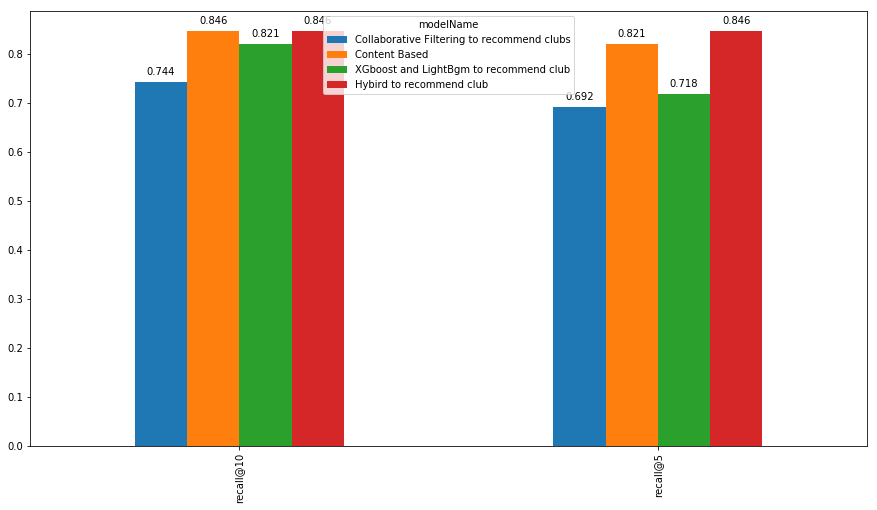

In [54]:
%matplotlib inline
ax = global_metrics_df.transpose().plot(kind='bar', figsize=(15,8))
for p in ax.patches:
    ax.annotate("%.3f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')